In [2]:
import numpy as np
import pandas as pd
import datetime

import re
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium_stealth import stealth
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import statistics

from alive_progress import alive_bar

In [3]:
def loadData():
    playerList = pd.read_csv('../data/player-list.csv')
    tournamentList = pd.read_csv('../data/tournament-list.csv')
    playerHistory = pd.read_csv('../data/player-history.csv')
    tdfile = pd.read_csv('../data/td-ratings.csv')

    playerHistory["Rank"] = pd.to_numeric(playerHistory["Rank"])
    playerHistory["Database#"] = pd.to_numeric(playerHistory["Database#"])
    playerHistory["USATT#"] = pd.to_numeric(playerHistory["USATT#"])
    playerHistory["Tournament Rating"] = pd.to_numeric(playerHistory["Tournament Rating"])
    playerHistory["League Rating"] = pd.to_numeric(playerHistory["League Rating"])
    playerHistory["Initial Rating"] = pd.to_numeric(playerHistory["Initial Rating"], errors='coerce')
    playerHistory["Final Rating"] = pd.to_numeric(playerHistory["Final Rating"], errors='coerce')
    playerHistory["Start Date"] = pd.to_datetime(playerHistory["Start Date"], errors='coerce')
    playerHistory["End Date"] = pd.to_datetime(playerHistory["End Date"], errors='coerce')

    count = playerHistory['Database#'].value_counts().to_frame()
    count['Database#'] = count.index
    count.index = [i for i in range(len(count))] # type: ignore
    playerList = playerList.merge(count)
    playerList = playerList.rename(columns={'count': 'Tournament Count'})

    tdfile = tdfile[['Member ID', 'Zip', 'State', 'Gender', 'Date of Birth']]
    tdfile.columns = ['USATT#', 'Zip', 'State', 'Gender', 'Date of Birth']
    playerList = playerList.merge(tdfile, how='left')

    return playerList, tournamentList, playerHistory

In [4]:
playerList, tournamentList, playerHistory = loadData()

C:\Users\hsu_s\AppData\Local\Temp\ipykernel_21804\1368135204.py:4: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  playerHistory = pd.read_csv('../data/player-history.csv')


In [5]:
def searchPlayer(name):
    name = name.split()
    for i in range(len(name)):
        name[i] = name[i].capitalize()
    if len(name) == 1:
        print(playerList[playerList['First Name'].str.contains(name[0])].to_string())
    else:
        print(playerList[(playerList['First Name'].str.contains(name[0])) & (playerList['Last Name'].str.contains(name[-1]))].to_string())

## Summary Statistics

In [6]:
def graphRating(player, lowerLim=0):
    ratings = player['Initial Rating'].to_numpy()

    startDate = player.loc[player.index[len(player)-1], 'Start Date']
    tournamentNum = len(player)
    timeline = np.zeros(tournamentNum)
    for i in range(tournamentNum):
        timeline[i] = (player.loc[player.index[i], 'Start Date'] - startDate).days
    name = player.loc[player.index[0], 'First Name'] + ' ' + player.loc[player.index[0], 'Last Name']

    plt.title(name)
    plt.ylim(lowerLim, 3000)
    plt.yticks(np.arange(lowerLim, 3000, 100))
    plt.ylabel('Rating')
    plt.xlabel('Days')
    plt.plot(timeline, ratings, linestyle='', marker='.')
    plt.show()

In [7]:
def plotDistribution(arr, xlabel, bins=100):
    plt.title('Distribution')
    plt.hist(arr, bins=bins)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.show()

In [8]:
searchPlayer('Stanley Hsu')

     Rank First Name Last Name  Database#  USATT#           Location                             Home Club  Tournament Rating Last Played Tournament  League Rating Last Played League Membership Expiration  Tournament Count    Zip State Gender Date of Birth
127   129    Stanley       Hsu     102103   97890  North Potomac, MD  MDTTC - Maryland Table Tennis Center               2509             08/25/2024           2186         02/07/2020                ACTIVE                90  20878    MD      M    2008-09-25


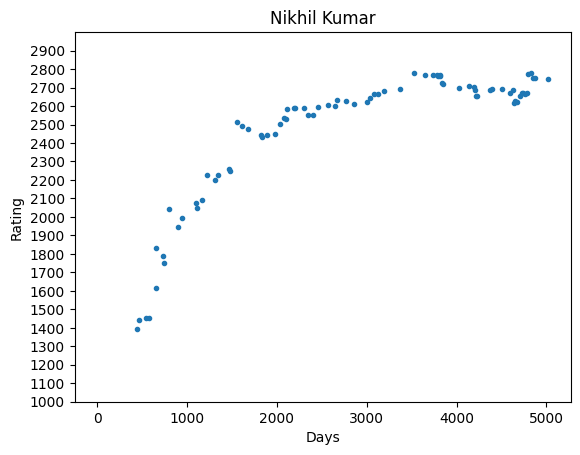

In [9]:
databaseID = 3998
player = playerHistory[playerHistory['Database#'] == databaseID]
graphRating(player, 1000)

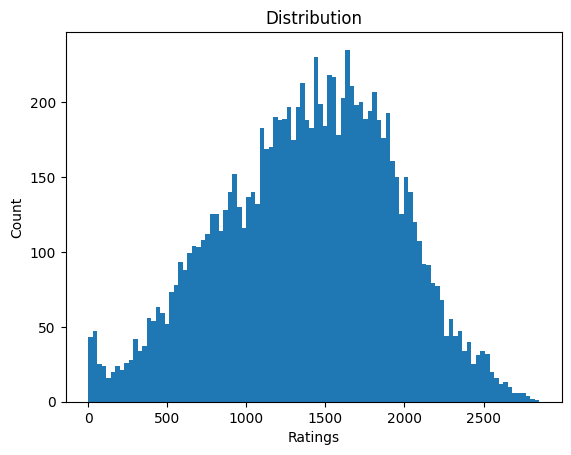

In [10]:
rated = playerList[playerList['Tournament Rating'] > 0]['Tournament Rating']
plotDistribution(rated, 'Ratings')

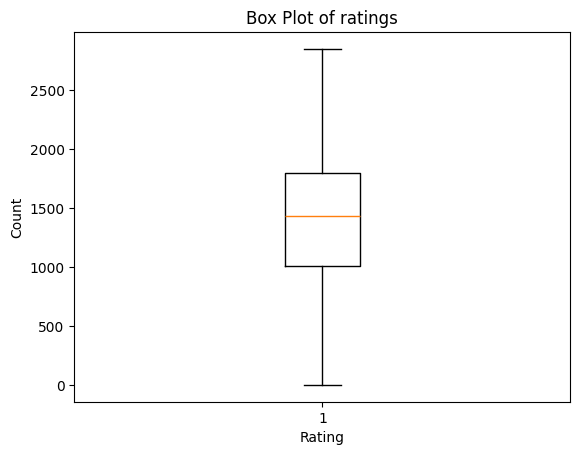

In [11]:
plt.title('Box Plot of ratings')
plt.boxplot(rated)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [ ]:
def getSummaryStats(data):
    mean = statistics.mean(data)
    median = statistics.median(data)
    std = statistics.stdev(data)
    quartiles = statistics.quantiles(data)
    iqr = quartiles[2] - quartiles[0]
    minimum = min(data)
    maximum = max(data)
    print('Mean:', mean)
    print('Median:', median)
    print('Standard Deviation:', std)
    print('Interquartile Range:', iqr)
    print('Minimum:', minimum)
    print('Maximum:', maximum)

In [13]:
getSummaryStats(rated)

Mean: 1391.1472498090145
Median: 1430.0
Standard Deviation: 547.4784125943094
Interquartile Range: 785.0
Minimum: 1
Maximum: 2851


## K-Means Clustering

In [14]:
from sklearn.cluster import KMeans

In [15]:
playerList['Date of Birth'] = pd.to_datetime(playerList['Date of Birth'])
unratedPlayerList = playerHistory[playerHistory['Initial Rating'] == 0][['Database#', 'Start Date']]
firstage = playerList[['First Name', 'Last Name', 'Database#', 'Tournament Rating', 'Tournament Count', 'Date of Birth', 'Last Played Tournament']].merge(unratedPlayerList)
firstage = firstage.dropna()
firstage['First Tournament Age'] = (firstage['Start Date'] - firstage['Date of Birth']).dt.days

In [16]:
scope = firstage[(firstage['First Tournament Age'] < 30000) & (firstage['First Tournament Age'] > 0) & (firstage['Tournament Count'] > 10)]
scope.head()

,First Name,Last Name,Database#,Tournament Rating,Tournament Count,Date of Birth,Last Played Tournament,Start Date,First Tournament Age
1,Lei,Kou,165420,2810,40,1987-11-20,04/07/2024,2019-05-12,11496
2,Kanak,Jha,3431,2806,67,2000-06-19,07/07/2024,2006-07-30,2232
4,Jinbao,Ma,121283,2774,44,2000-02-18,09/02/2024,2017-11-18,6483
8,Nikhil,Kumar,3998,2753,91,2003-01-01,09/02/2024,2010-12-05,2895
9,Xin,Zhou,9141,2751,49,1988-12-30,12/21/2023,2009-11-29,7639


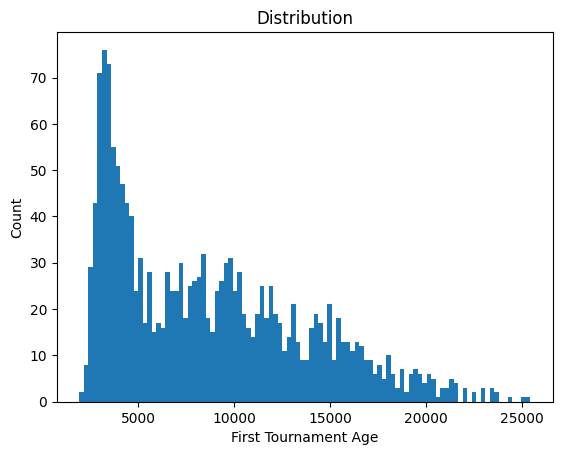

In [17]:
plotDistribution(scope['First Tournament Age'], 'First Tournament Age')

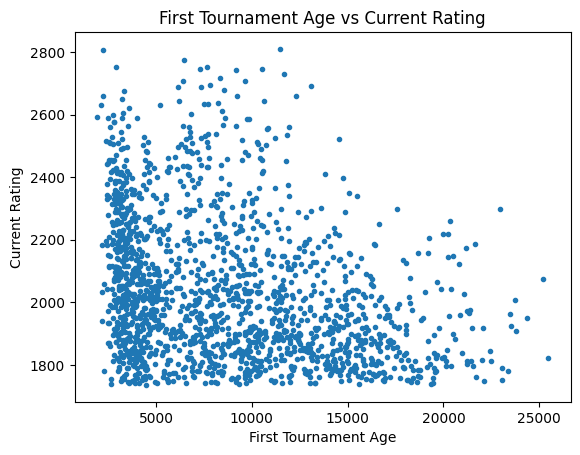

In [18]:
plt.scatter(scope['First Tournament Age'], scope['Tournament Rating'], marker='.')
plt.title('First Tournament Age vs Current Rating')
plt.xlabel('First Tournament Age')
plt.ylabel('Current Rating')
plt.show()

In [19]:
np.corrcoef(scope['First Tournament Age'], scope['Tournament Rating'])

array([[ 1.       , -0.3009577],
       [-0.3009577,  1.       ]])

In [20]:
males = playerList[playerList['Gender'] == 'M']['Tournament Rating'].reset_index(drop=True)
females = playerList[playerList['Gender'] == 'F']['Tournament Rating'].reset_index(drop=True)
genderratings = pd.DataFrame({'Male Ratings': males, 'Female Ratings': females})

Text(0, 0.5, 'Rating')

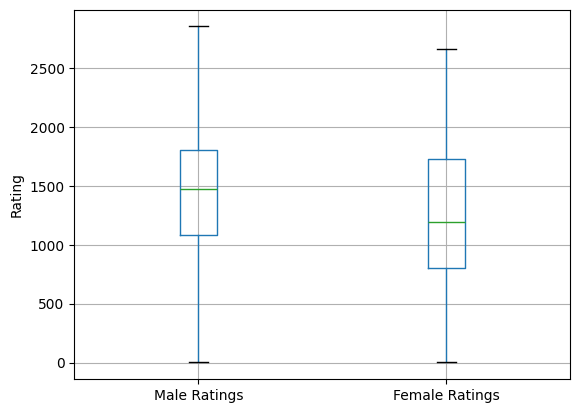

In [21]:
grboxplot = genderratings.boxplot()
grboxplot.set_ylabel('Rating')

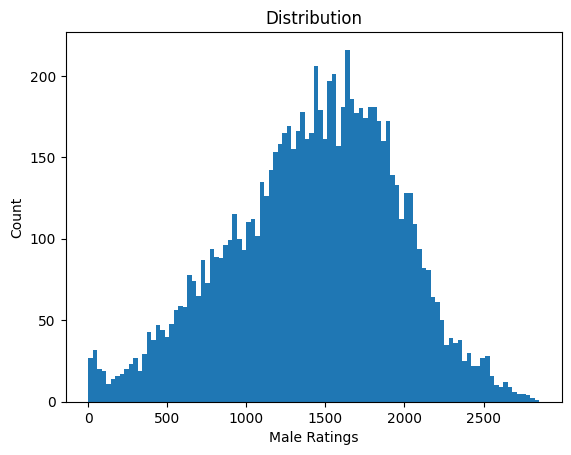

Mean: 1425.5364451598068
Median: 1468.5
Standard Deviation: 529.5189812409089
Interquartile Range: 726.25
Minimum: 1
Maximum: 2851


In [22]:
plotDistribution(males, 'Male Ratings')
getSummaryStats(males)

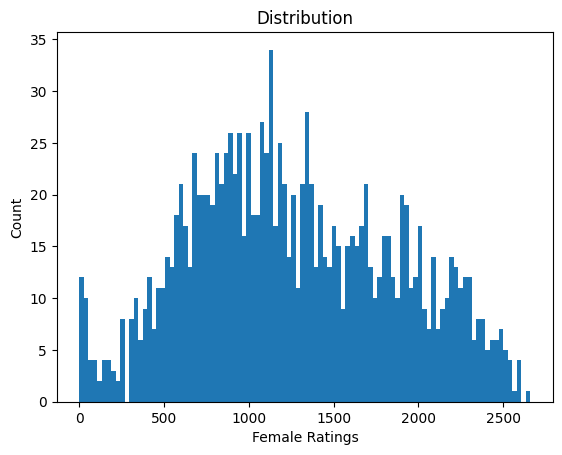

Mean: 1265.6659209545116
Median: 1195
Standard Deviation: 606.0152172444037
Interquartile Range: 923.0
Minimum: 2
Maximum: 2660


In [23]:
plotDistribution(females, 'Female Ratings')
getSummaryStats(females)

In [24]:
zscore = ((2509) - statistics.mean(rated)) / statistics.stdev(rated)
zscore

2.0418206900503546

In [25]:
from scipy.stats import norm
norm.cdf(zscore)

0.9794153394319197

In [26]:
norm.ppf(0.99, 0) * statistics.stdev(rated) + statistics.mean(rated)

2664.7724910310403

In [27]:
firstage['Last Played Tournament'] = pd.to_datetime(firstage['Last Played Tournament'])
firstage['Tournament Date Range'] = (firstage['Last Played Tournament'] - firstage['Start Date']).dt.days
firstage.head()

,First Name,Last Name,Database#,Tournament Rating,Tournament Count,Date of Birth,Last Played Tournament,Start Date,First Tournament Age,Tournament Date Range
0,Kalinikos,Kreanga,69780,2851,3,1900-01-01,2023-10-29,2001-07-08,37078,8148
1,Lei,Kou,165420,2810,40,1987-11-20,2024-04-07,2019-05-12,11496,1792
2,Kanak,Jha,3431,2806,67,2000-06-19,2024-07-07,2006-07-30,2232,6552
4,Jinbao,Ma,121283,2774,44,2000-02-18,2024-09-02,2017-11-18,6483,2480
5,Taehyun,Kim,182757,2772,7,1900-01-01,2024-09-08,2023-11-24,45252,289


In [28]:
firstage['Tournament Frequency'] =  365 * firstage['Tournament Count'] / firstage['Tournament Date Range']
firstage = firstage[firstage['Tournament Date Range'] > 50]
firstage = firstage[firstage['Date of Birth'] > datetime.datetime(1900, 1, 1)]
firstage.head()

,First Name,Last Name,Database#,Tournament Rating,Tournament Count,Date of Birth,Last Played Tournament,Start Date,First Tournament Age,Tournament Date Range,Tournament Frequency
1,Lei,Kou,165420,2810,40,1987-11-20,2024-04-07,2019-05-12,11496,1792,8.147321
2,Kanak,Jha,3431,2806,67,2000-06-19,2024-07-07,2006-07-30,2232,6552,3.732448
4,Jinbao,Ma,121283,2774,44,2000-02-18,2024-09-02,2017-11-18,6483,2480,6.475806
6,Taimu,Arinobu,121652,2769,3,1994-10-12,2024-08-04,2017-12-17,8467,2422,0.452106
8,Nikhil,Kumar,3998,2753,91,2003-01-01,2024-09-02,2010-12-05,2895,5020,6.616534


In [29]:
firstage['Age'] = (datetime.datetime.now() - firstage['Date of Birth']).dt.days # type: ignore
firstage.head()

,First Name,Last Name,Database#,Tournament Rating,Tournament Count,Date of Birth,Last Played Tournament,Start Date,First Tournament Age,Tournament Date Range,Tournament Frequency,Age
1,Lei,Kou,165420,2810,40,1987-11-20,2024-04-07,2019-05-12,11496,1792,8.147321,13487
2,Kanak,Jha,3431,2806,67,2000-06-19,2024-07-07,2006-07-30,2232,6552,3.732448,8892
4,Jinbao,Ma,121283,2774,44,2000-02-18,2024-09-02,2017-11-18,6483,2480,6.475806,9014
6,Taimu,Arinobu,121652,2769,3,1994-10-12,2024-08-04,2017-12-17,8467,2422,0.452106,10969
8,Nikhil,Kumar,3998,2753,91,2003-01-01,2024-09-02,2010-12-05,2895,5020,6.616534,7966


In [30]:
np.corrcoef(firstage['Age'], firstage['Tournament Frequency'])

array([[ 1.        , -0.39882292],
       [-0.39882292,  1.        ]])

In [31]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(firstage[['Age']], firstage[['Tournament Frequency']])
print(model.coef_, model.intercept_)

[[-0.00027015]] [8.34537186]


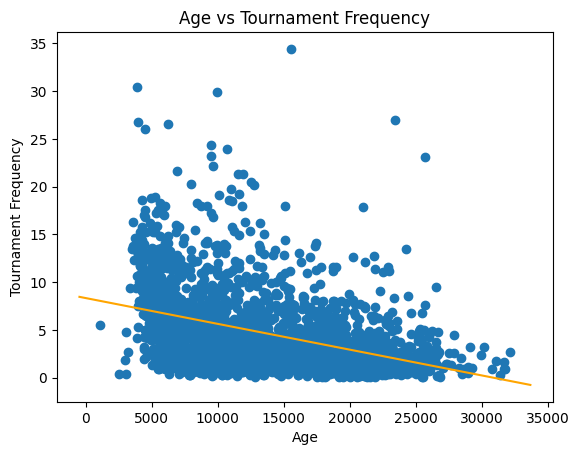

In [32]:
plt.scatter(firstage['Age'], firstage['Tournament Frequency'])
plt.xlabel('Age')
plt.ylabel('Tournament Frequency')
plt.title('Age vs Tournament Frequency')
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = model.intercept_[0] + model.coef_[0][0] * x_vals
plt.plot(x_vals, y_vals, color='orange')
plt.show()